Setup packages and read data

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [131]:
ets = pd.read_csv('ETS_Database_v49_Jul22.csv', sep='\t')
ets.head()

,country,country_code,ETS information,main activity sector name,unit,value,year
0,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,498797.0,2005
1,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,383157.0,2013
2,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,351210.0,2017
3,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,335835.0,2018
4,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,299741.0,2021


In [132]:
ets.rename(columns={'ETS information':'info', 'main activity sector name':'sector'}, inplace=True)

Identify variables

In [133]:
rows_to_drop = {}
def add_rows_to_drop(colname, *rowvalues):
    if not colname in rows_to_drop: rows_to_drop[colname] = []
    rows_to_drop[colname].extend(rowvalues)

In [134]:
countries = ets[['country','country_code']].drop_duplicates()
add_rows_to_drop('country', 'NER 300 auctions')

In [135]:
info = ets['info'].unique()
info.sort()
add_rows_to_drop('info', '1. Total allocated allowances (EUA or EUAA)', '1.1 Freely allocated allowances', '2. Verified emissions', '4. Total surrendered units')


In [136]:
sectors = ets['sector'].unique()
add_rows_to_drop('sector', '21-99 All industrial installations (excl. combustion)', '20-99 All stationary installations')

In [137]:
units = ets['unit'].unique()
del ets['unit']

In [138]:
year = ets['year'].unique()
add_rows_to_drop('year', 'Total 1st trading period (05-07)', 'Total 2nd trading period (08-12)', 'Total 3rd trading period (13-20)', 'Total 4th trading period (21-30)')

drop rows:

In [139]:
for colname, values in rows_to_drop.items(): ets.drop(ets.loc[ets[colname].isin(values)].index, inplace=True)

In [146]:
hist_em = ets.copy()
hist_em

,country,country_code,info,sector,value,year
6,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,481340.0,2011
7,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,478462.0,2012
8,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2017
9,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2018
10,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2021
...,...,...,...,...,...,...
74915,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,217488.0,2016
74916,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,222518.0,2019
74919,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2011
74920,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2012


In [160]:
np.sum([np.sum(hist_em.loc[hist_em['sector'].str.contains(str(sec))]['value']) for sec in range(21,100)])

25447358895.0

In [161]:
grouped = hist_em.groupby(by=['year', 'sector'])
hist_em = grouped.apply('sum')

C:\Users\alast\AppData\Local\Temp\ipykernel_1064\2281685874.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hist_em = grouped.apply('sum')


In [174]:
hist_em.index

MultiIndex([('2005',                                       '10 Aviation'),
            ('2005',                            '20 Combustion of fuels'),
            ('2005',                       '21  Refining of mineral oil'),
            ('2005',                            '22  Production of coke'),
            ('2005',                '23 Metal ore roasting or sintering'),
            ('2005',               '24  Production of pig iron or steel'),
            ('2005',     '25 Production or processing of ferrous metals'),
            ('2005',                '26 Production of primary aluminium'),
            ('2005',              '27 Production of secondary aluminium'),
            ('2005', '28 Production or processing of non-ferrous metals'),
            ...
            ('2022',                             '35 Production of pulp'),
            ('2022',               '36 Production of paper or cardboard'),
            ('2022',                     '37 Production of carbon black'),
         

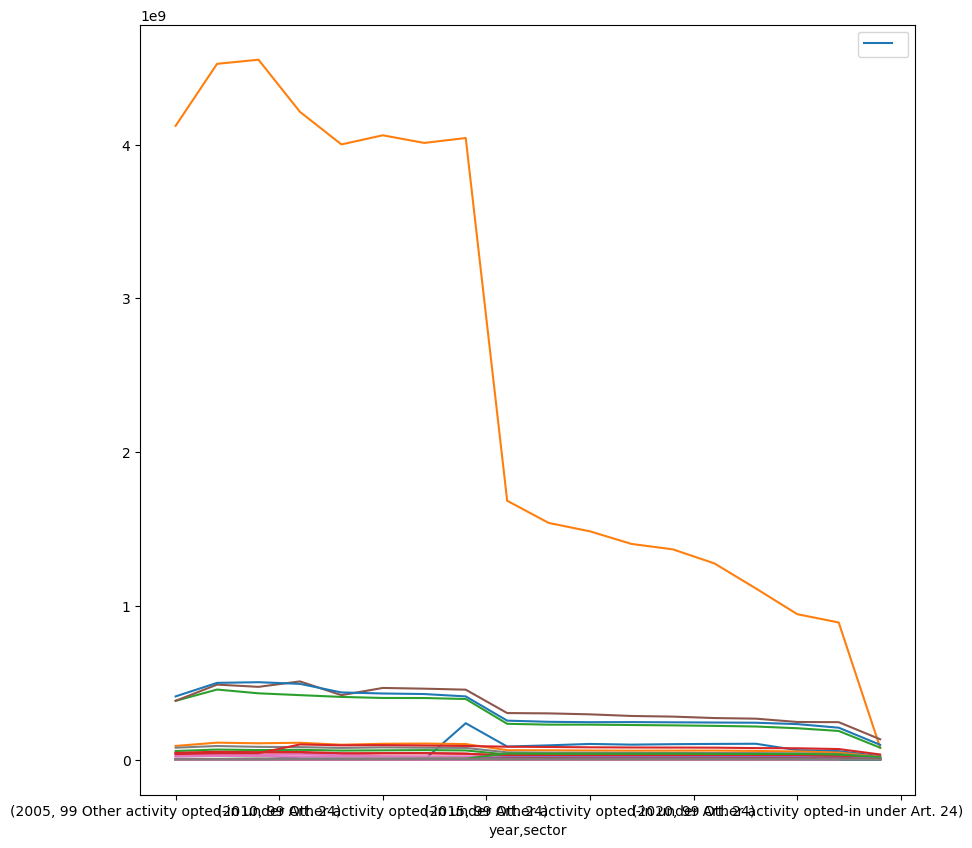

In [184]:
fig, ax = plt.subplots(figsize=(10,10))
for sector, group in hist_em.groupby('sector'):
    group.plot(y='value', ax=ax, label=sector)

ax.legend(labels=[''])